## Panan Temperature Quick

Note, this has been scrapped due to intake issues.

In [ ]:
import intake

import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [ ]:
#Importing data
pancontrol01 = intake.open_esm_datastore('/home/272/kc5856/panantrial/experiment_datastore.json', columns_with_iterables=['variable'])
pantrial01 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/experiment_datastore.json', columns_with_iterables=['variable'])
pancontrol005 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/panant_005_zstar_access_yr2.json', columns_with_iterables=['variable'])
pantrial005 = intake.open_esm_datastore('/home/272/kc5856/panantrial/panant_005_zstar_MWonly.json', columns_with_iterables=['variable'])

In [ ]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)

### Defining variables

In [ ]:
#Time variant variables #Can this be condensed?
control01_temp = pancontrol01.search(variable="thetao", frequency="1mon").to_dask()#add chunks line in to.dask()
trial01_temp = pantrial01.search(variable="thetao", frequency="1mon").to_dask()
control005_temp = pancontrol005.search(variable=["thetao"],frequency="1mon",file_id=["XXXXXXXX_ocean_month_z"]).to_dask()
trial005_temp = pantrial005.search(variable="thetao", frequency="1mon").to_dask()

In [ ]:
#Time invariant variables
data01_fixed = pancontrol01.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()
data005_fixed = pancontrol005.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()
vol01 = pancontrol01.search(variable=["volcello"],path=".*output021.*",file_id=["XXXXXXXX_ocean_month_z"]).to_dask()
vol005 = pancontrol005.search(variable=["volcello"],path=".*output021.*",file_id=["XXXXXXXX_ocean_month_z"]).to_dask()

In [ ]:
#Area weighting
areacello01 = data01_fixed.areacello
areacello005 = data005_fixed.areacello
thick01 = vol01 / areacello01
thick005 = vol005 / areacello005

In [ ]:
thick01 = thick01.load()
thick005 = thick005.load()

### Defining shelf mask

In [ ]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

### Panan01

In [11]:
depth01 = data01_fixed.deptho
land_mask = (depth01*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth01, 'mom6_01')

In [ ]:
cont01_500_time = control01_temp.thetao.sel(z_l=slice(0,520)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))
pert01_500_time = trial01_temp.thetao.sel(z_l=slice(0,520)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))

In [ ]:
cont01_500_time = cont01_500_time.load()
pert01_500_time = pert01_500_time.load()

2025-04-26 13:32:41,029 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/nanny.py", line 1019, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loo

Text(0.5, 1.0, 'Panan01 Time Series of Temperature for shelf top 500m')

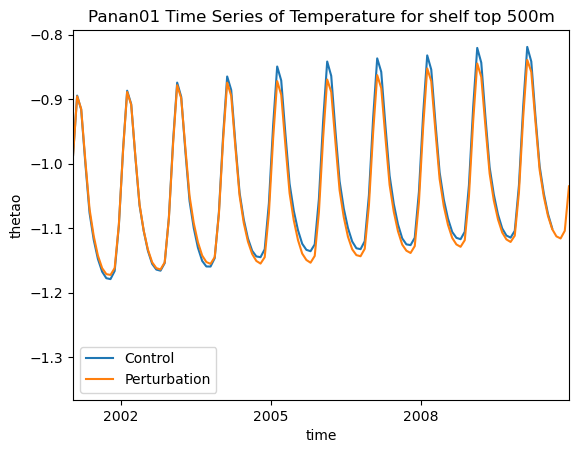

In [12]:
cont01_500_time.plot(label="Control")
pert01_500_time.plot(label="Perturbation")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Panan01 Time Series of Temperature for shelf top 500m")

In [11]:
cont01_single = control01_temp.thetao.sel(z_l=500,method='nearest').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))
pert01_single = trial01_temp.thetao.sel(z_l=500,method='nearest').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))

In [12]:
cont01_single = cont01_single.load()
pert01_single = pert01_single.load()

Text(0.5, 1.0, 'Panan01 Time Series of Temperature for shelf top 500m')

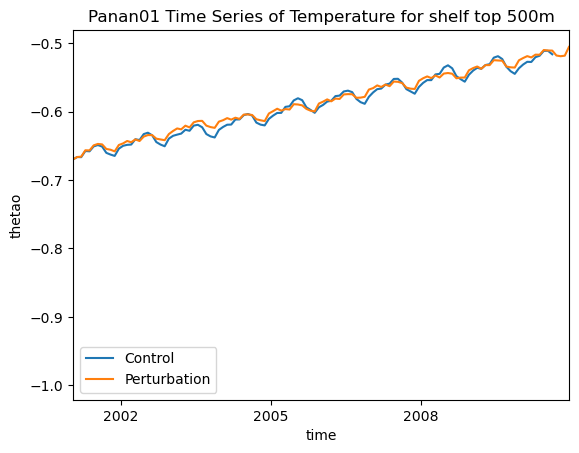

In [13]:
cont01_single.plot(label="Control")
pert01_single.plot(label="Perturbation")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Panan01 Time Series of Temperature for shelf top 500m")

Hm maybe not this then, doesn't look great.

Now doing time series of just the top 200 m.

In [12]:
cont01_200_time = control01_temp.thetao.sel(z_l=slice(0,220)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))
pert01_200_time = trial01_temp.thetao.sel(z_l=slice(0,220)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))

In [13]:
cont01_200_time = cont01_200_time.load()
pert01_200_time = pert01_200_time.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 16.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Panan01 Time Series of Temperature for shelf top 200m')

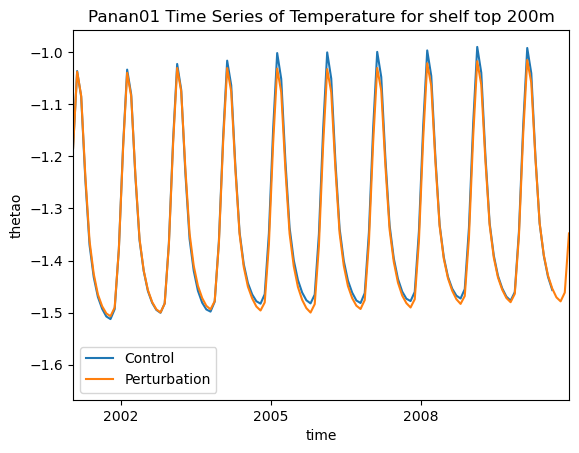

In [13]:
cont01_200_time.plot(label="Control")
pert01_200_time.plot(label="Perturbation")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Panan01 Time Series of Temperature for shelf top 200m")

Between 100 and 200 m

In [ ]:
cont01_200_tr = control01_temp.thetao.sel(z_l=slice(100,220)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))
pert01_200_tr = trial01_temp.thetao.sel(z_l=slice(100,220)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))

In [ ]:
cont01_200_tr = cont01_200_tr.load()
pert01_200_tr = pert01_200_tr.load()

In [14]:
anom01_200 = pert01_200_tr - cont01_200_tr
anom01_200 = anom01_200.load()

### Panan005

In [ ]:
depth005 = data005_fixed.deptho
land_mask = (depth005*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth005, 'mom6_005')

Trying top 500 m depth average.

In [ ]:
# Slicing first
cont005_500_time = control005_temp.thetao.sel(z_l=slice(0,520)).sel(time=slice('2001-01-01','2010-12-31')).sel(yh=slice(None,-59))
pert005_500_time = trial005_temp.thetao.sel(z_l=slice(0,520)).sel(time=slice('2001-01-01','2010-12-31')).sel(yh=slice(None,-59))

In [14]:
# Weighting and means
cont005_500_time = cont005_500_time.weighted(thick005['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello005.fillna(0)).mean(dim=('xh','yh'))
pert005_500_time = pert005_500_time.weighted(thick005['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello005.fillna(0)).mean(dim=('xh','yh'))

In [ ]:
cont005_500_time = cont005_500_time.load()
pert005_500_time = pert005_500_time.load()

In [ ]:
cont005_500_time.plot(label="Control")
pert005_500_time.plot(label="Perturbation")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Panan005 Time Series of Temperature for shelf top 500m")

Giving up and doing 100m to 200m depth

In [10]:
# Slicing first
cont005_200_tr = control005_temp.thetao.sel(time=slice('2001-01-01','2010-12-31')).sel(yh=slice(None,-59)).sel(z_l=slice(100,220))
pert005_200_tr = trial005_temp.thetao.sel(time=slice('2001-01-01','2010-12-31')).sel(yh=slice(None,-59)).sel(z_l=slice(100,220))

In [12]:
cont005_200_tr = cont005_200_tr.load()
pert005_200_tr = pert005_200_tr.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 16.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 16.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [13]:
# Depth averaging
cont005_200_tr = cont005_200_tr.weighted(thick005['z_l'].fillna(0)).mean(dim='z_l')
pert005_200_tr = pert005_200_tr.weighted(thick005['z_l'].fillna(0)).mean(dim='z_l')

In [14]:
cont005_200_tr = cont005_200_tr.load()
pert005_200_tr = pert005_200_tr.load()

In [15]:
# Average of shelf only
cont005_200_tr = cont005_200_tr.where(shelf_mask == 1).weighted(areacello005.fillna(0)).mean(dim=('xh','yh'))
pert005_200_tr = pert005_200_tr.where(shelf_mask == 1).weighted(areacello005.fillna(0)).mean(dim=('xh','yh'))

In [ ]:
cont005_200_tr = cont005_200_tr.load()
pert005_200_tr = pert005_200_tr.load()

In [25]:
cont005_200_tr.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/temp_pan005_control_1.nc')
pert005_200_tr.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/temp_pan005_melt_1.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 6.66 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


FutureCancelledError: ('store-map-246fac2b60eff2e569c20d56323d9998', 0) cancelled for reason: scheduler-connection-lost.
Client lost the connection to the scheduler. Please check your connection and re-run your work.

In [ ]:
control_200t_005 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/temp_pan005_control_1.nc', chunks = {'isopycnal_bins': 1})
melt_200t_005 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/temp_pan005_melt_1.nc', chunks = {'isopycnal_bins': 1})

In [ ]:
control_200t_005.plot(label="Control")
melt_200t_005.plot(label="Perturbation")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Panan005 Time Series of Temperature for shelf 100 to 200m")

In [ ]:
anom005_200 = melt_200t_005 - control_200t_005
anom005_200 = anom005_200.load()

In [ ]:
anom01_200.plot(label="1/10 anomaly")
anom005_200.plot(label="1/20 anomaly")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Time Series of Temperature Anomaly for shelf top 200m")